In [1]:
import math
import string
import random
from collections import defaultdict, Counter
import itertools

import dougnet as dn
from dougnet.training import DataLoader
from dougnet.data import LoadBB

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

In this notebook I train RNN models with both DougNet and PyTorch (for comparison) using the movie script, Beavis and Butt-head do America, as data.  I consider
- a character level model for classification
- and a character level model for next character prediction.

Additionally, I use my trained model for next character prediction to auto-regressively generate new text in the style of the Beavis and Butt-head script.

# Define training/plotting utility functions

In [2]:
def train_dougnet(model, dl_class, forward_func, init_weights_func, batch_size, record_weights=False):
    """
    Main function for training the dougnet RNNs in this notebook.  This function requires a data loader 
    class with a load() method, a function for computing the forward pass of the RNN and a function for 
    initializing the weights of the RNN model.  Training and validation data also need to be defined as 
    the global variables: X_TRAIN, Y_TRAIN, X_VALID and Y_VALID.
    """
    # initialize weights/biases and copy initialized weights/biases for training pytorch
    graph = dn.ComputationGraph()
    weights, biases = init_weights_func(model)
    graph.initialize_params(SEED_WEIGHTS)
    print(f"number of model parameters: {len(graph)}")
    initial_weights = {k:(v.output.copy() if type(v) != list else [vv.output.copy() for vv in v]) 
                       for k, v in weights.items()}

    # train
    optim = dn.optim.Adam(graph, eta=LEARNING_RATE)
    dataloader = dl_class(X_TRAIN, Y_TRAIN, batch_size, SEED_DATALOADER)
    progress = defaultdict(list)
    with tqdm(range(NUM_ITERS), desc="iter", unit="iter", bar_format='{l_bar}{bar:15}{r_bar}{bar:-10b}') as trange:
        for it in trange:
            for inputs, targets in dataloader.load():
                _, _, _ = forward_func(model, graph, optim, inputs, targets, weights, biases)

            # record progress
            if it % EVAL_CADENCE == 0:  
                loss_train, acc_train, _ = forward_func(model, graph, optim, X_TRAIN, Y_TRAIN, 
                                                        weights, biases, train=False)
                loss_valid, acc_valid, cm = forward_func(model, graph, optim, X_VALID, Y_VALID, 
                                                         weights, biases, train=False)
                progress['loss_train'].append(loss_train) 
                progress['loss_valid'].append(loss_valid)  
                progress['acc_train'].append(acc_train)  
                progress['acc_valid'].append(acc_valid)
                progress['confusion_matrices'].append(cm)
                if record_weights:
                    progress['weights'].append({k:v.output.copy() for k, v in weights.items()})
                    progress['biases'].append({k:v.output.copy() for k, v in biases.items()})

                trange.set_postfix(loss=f"{round(loss_train, 2)}/{round(loss_valid, 2)}", 
                                   accuracy=f"{round(100 * acc_train, 2)}/{round(100 * acc_valid, 2)}")
    return progress, initial_weights

In [3]:
def train_torch(model, dl_class, forward_func, init_weights_func, batch_size, weights):    
    """Main function for training the torch RNNs in this notebook."""
    # initialize torch weights to same initial weights used to train dn model
    init_weights_func(model, weights)
    
    # train
    optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    dataloader = dl_class(X_TRAIN, Y_TRAIN, batch_size, SEED_DATALOADER)
    progress = defaultdict(list)
    with tqdm(range(NUM_ITERS), desc="iter", unit="iter", bar_format='{l_bar}{bar:15}{r_bar}{bar:-10b}') as trange:
        for it in trange:
            for inputs, targets in dataloader.load():
                loss, _ = forward_func(model, optim, inputs, targets)
           
            # record progress
            if it % EVAL_CADENCE == 0:  
                with torch.no_grad():
                    loss_train, acc_train = forward_func(model, optim, X_TRAIN, Y_TRAIN, train=False)
                    loss_valid, acc_valid = forward_func(model, optim, X_VALID, Y_VALID, train=False)
                    progress['loss_train'].append(loss_train) 
                    progress['loss_valid'].append(loss_valid)  
                    progress['acc_train'].append(acc_train)  
                    progress['acc_valid'].append(acc_valid) 
                    
                    trange.set_postfix(loss=f"{round(loss_train, 2)}/{round(loss_valid, 2)}", 
                                       accuracy=f"{round(100 * acc_train, 2)}/{round(100 * acc_valid, 2)}")
    return progress

In [4]:
def ohe(ints, cardinality):
    """one-hot encode arrays on integers"""
    batch_size = ints.shape[0]
    X_ohe = np.zeros((batch_size, cardinality), dtype=np.float32)
    X_ohe[range(batch_size), ints] = 1.
    return X_ohe.T

In [5]:
def plot_results(progress_dict_dn, progress_dict_torch, eval_cadence, title):
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6))
    fig.suptitle(f'{title}', fontsize=16)
    
    axs[0][0].plot(np.arange(1, len(progress_dict_dn["loss_train"]) + 1) * eval_cadence, progress_dict_dn["loss_train"])
    axs[0][0].plot(np.arange(1, len(progress_dict_dn["loss_valid"]) + 1) * eval_cadence, progress_dict_dn["loss_valid"])
    axs[0][0].set_ylabel("loss")
    axs[0][0].set_title("dougnet")

    axs[0][1].plot(np.arange(1, len(progress_dict_torch["loss_train"]) + 1) * eval_cadence, progress_dict_torch["loss_train"])
    axs[0][1].plot(np.arange(1, len(progress_dict_torch["loss_valid"]) + 1) * eval_cadence, progress_dict_torch["loss_valid"])
    axs[0][1].set_title("pytorch")

    axs[1][0].plot(np.arange(1, len(progress_dict_dn["acc_train"]) + 1) * eval_cadence, progress_dict_dn["acc_train"])
    axs[1][0].plot(np.arange(1, len(progress_dict_dn["acc_valid"]) + 1) * eval_cadence, progress_dict_dn["acc_valid"])
    axs[1][0].set_xlabel("epoch/iteration")
    axs[1][0].set_ylabel("accuracy")

    axs[1][1].plot(np.arange(1, len(progress_dict_torch["acc_train"]) + 1) * eval_cadence, progress_dict_torch["acc_train"])
    axs[1][1].plot(np.arange(1, len(progress_dict_torch["acc_valid"]) + 1) * eval_cadence, progress_dict_torch["acc_valid"])
    axs[1][1].set_xlabel("epoch/iteration")
    
    best_index_dn = np.argmin(np.array(progress_dict_dn["loss_valid"]))
    best_index_torch = np.argmin(np.array(progress_dict_torch["loss_valid"]))
      
    print(f"best dougnet validation accuracy = {round(progress_dict_dn['acc_valid'][best_index_dn], 3)}")
    print(f"best pytorch validation accuracy = {round(progress_dict_torch['acc_valid'][best_index_torch], 3)}")

# Load data

Let's load the Beavis and Butt-head script and take a look at it.

In [6]:
# text data
BB_TEXT = LoadBB() 

STOI = string.printable.index # string-to-index mapping
ITOS = lambda x: string.printable[x] # index-to-string mapping

In [7]:
char_set = set(list(BB_TEXT))
print('total text length:', len(BB_TEXT))
print('number unique characters:', len(char_set))

total text length: 110009
number unique characters: 79


In [8]:
# take a look at the beginning and end of the script

print('=' * 30, 'beginning of script', '=' * 30)
print(BB_TEXT[:300])
print('\n')
print('=' * 30, 'end of script', '=' * 30)
print(BB_TEXT[-300:])

============================== beginning of script ==============================

	
	
	INT.  B&B'S HOME - DAY
	
	
					BEAVIS (O.C.)
			Butt-Head! Butt-Head! Hey, Butt-Head!
	
	Butt-Head is dead asleep on the couch. Beavis shakes him.
	
					BEAVIS
			Butt-Head, wake up, wake up!
	
	Butt-Head comes around.
	
					BUTT-HEAD
			Dammit, Beavis, I was about to score.
			Huh huh.
	
	


============================== end of script ==============================
dill, um, face...
	
					BEAVIS
			Um... ass... head...
	
					BUTT-HEAD
			Uh... butt-snatch...
	
					BEAVIS
			You already said that, Butt-Head.
	
					BUTT-HEAD
			Oh, uh, I mean, uh, ass-goblin...
	
					B&B
			Huh huh huh...
	
	B&B head off into the sunset, trading lame insults as we FADE OUT.


In [9]:
# take a look at the raw text characters in the B&B script.
BB_TEXT[:300]

"\n\t\n\t\n\tINT.  B&B'S HOME - DAY\n\t\n\t\n\t\t\t\t\tBEAVIS (O.C.)\n\t\t\tButt-Head! Butt-Head! Hey, Butt-Head!\n\t\n\tButt-Head is dead asleep on the couch. Beavis shakes him.\n\t\n\t\t\t\t\tBEAVIS\n\t\t\tButt-Head, wake up, wake up!\n\t\n\tButt-Head comes around.\n\t\n\t\t\t\t\tBUTT-HEAD\n\t\t\tDammit, Beavis, I was about to score.\n\t\t\tHuh huh.\n\t\n\t"

The script contains a good amount of special formatting for indentation using the `\n` and `\t` characters.  Hopefully the RNN that I train for text generation will be able to replicate this formatting.

To train my models, it is more convenient to work with integer data than with strings.  I therefore require a dictionary which contains a pre-defined set of strings and maps each unique string to a unique integer.  For this mapping I use the set of characters in `string.printable`.

In [10]:
# make sure all chars in the script also in string.printable 
assert all(char in string.printable for char in char_set)

# print characters
print("Printed characters in string.printable: ")
print(string.printable)
print("\n")

# check out raw text characters of string.printable 
print("Raw characters in string.printable: ")
string.printable

Printed characters in string.printable: 
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



Raw characters in string.printable: 


'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

The global function, `STOI`, uses `string.printable` to map from a string to integer (the integer being the index position in `string.printable` corresponding to the to the desired string).  The global function, `ITOS` performs the reverse mapping.

In [11]:
print(STOI("a"))
print(ITOS(10))

10
a


# Character level RNN for classification

In this section I will build RNN classifiers which input a line in the script spoken by a character and classifies whether the line was spoken by Beavis, Butt-head or another character (a 3-class classifier).  

Since each input (character line) can have a different sequence length, I train my models with a mini-batch size of 1. I do this because I have not implemented any padding functionality in DougNet (like the padding functionality implemented in PyTorch) which would allow for mini-batches with examples of varying sequence lengths.

The model architecture I use is a 2-layer RNN where the last hidden unit in the RNN is fed into an MLP classifer which consists of a single hidden layer with dropout for regularization and a final output layer to compute logits as shown in the figure below:

|                                                |        |                                                  |        |                                      |
|:----------------------------------------------:|:------:|:------------------------------------------------:|:------:|:------------------------------------:|
|                                                |        |                                                  |        |FC layer to predict logits of target  | 
|                                                |        |                                                  |        |$\uparrow$                            |
|                                                |        |                                                  |        |dropout                               | 
|                                                |        |                                                  |        |$\uparrow$                            | 
|                                                |        |                                                  |        |relu                                  | 
|                                                |        |                                                  |        |$\uparrow$                            | 
|                                                |        |                                                  |        |FC layer                              | 
|                                                |        |                                                  |        |$\uparrow$                            |
|$H_{0}^2\rightarrow RNN~Cell\rightarrow H_{1}^2$|$\ldots$|$H_{t-1}^2\rightarrow RNN~Cell\rightarrow H_{t}^2$|$\ldots$|$H_{T-1}^2\rightarrow RNN~Cell~~~~~~~$| 
|$\uparrow$                                      |        |$\uparrow$                                        |        |$\uparrow$                            |
|$H_{0}^1\rightarrow RNN~Cell\rightarrow H_{1}^1$|$\ldots$|$H_{t-1}^1\rightarrow RNN~Cell\rightarrow H_{t}^1$|$\ldots$|$H_{T-1}^1\rightarrow RNN~Cell~~~~~~~$|   
|$\uparrow$                                      |        |$\uparrow$                                        |        |$\uparrow$                            | 
|embedding                                       |        |embedding                                         |        |embedding                             | 
|$\uparrow$                                      |        |$\uparrow$                                        |        |$\uparrow$                            |
|$x_{1}$                                         |        |$x_{t}$                                           |        |$x_{T}$                               | 

In [12]:
# seeds
SEED_PERMUTE_DATA = 1
SEED_DATALOADER = 4
SEED_WEIGHTS = 9
SEED_DROPOUT = 16

# data parameters
PERCENT_TRAINING_DATA = 0.8
TARGET2INT = {"BEAVIS": 0, "BUTT-HEAD": 1, "NOT B&B": 2}

# model parameters
VOCAB_SIZE = len(string.printable)
OUTPUT_DIM = 3
INPUT_DIM = 64
HIDDEN_DIM = 128
FC_DIM = 100
NUM_LAYERS = 2

# training parameters
NUM_ITERS = 40_000
LEARNING_RATE = .00001
EVAL_CADENCE = 1_000

## Process/prep data

In [13]:
def process_text_for_classifier():
    """parse B&B script to obtain a list of tuples giving [(character, line spoken), ...(character, line spoken)]"""
    # parse script text
    parsed_text = [s for s in BB_TEXT.split("\n") if s.startswith("\t\t\t") and not s.startswith("\t\t\t\t\t(")]
    character = parsed_text[0][5:].replace(' (O.C.)', '')
    dialogue = parsed_text[1][3:]

    # iterate through parsed text to generate a dictionary where keys are characters in the script
    # and values are their lines
    script_lines = defaultdict(list)
    for line in parsed_text[2:]:
        if line.startswith("\t\t\t\t\t"):
            # new character speaking
            script_lines[character].append(dialogue)
            dialogue = ""
            character = line[5:]
            for x in [' (O.S.)', ' (O.C.)', ' (V.O.)', ' (CONT.)', ' (O.S./CONT.)']:
                character = character.replace(x, '')
        else:
            if dialogue == "":
                dialogue += line[3:]
            else:
                dialogue += " "
                dialogue += line[3:]
            
    # Beavis is Cornholio, so include BEAVIS/CORNHOLIO's lines into Beavis'
    script_lines["BEAVIS"] = script_lines["BEAVIS"] + script_lines['BEAVIS/CORNHOLIO']
    del script_lines['BEAVIS/CORNHOLIO']

    # delete characters that are somewhat like Beavis and somewhat like Butt-head to not confuse my classifier
    # (I'll) be classifying Beavis/Butt-head/Not B&B
    del script_lines['B&B/DUMB GUY/DUMBER GUY']
    del script_lines['B&B']
    del script_lines['BEAVIS/SPERM']
    del script_lines['BEAVIS & BUTT-HEAD']

    # merge top-5 non-Beavis/Butt-head characters into a "NOT B&B"
    # the top-5 results in a roughly balanced dataset (# lines BEAVIS ~= # lines BUTT-HEAD ~=  # lines NOT B&B)
    top5_not_bb = [x[0] for x in sorted([(k, len(v)) for k, v in script_lines.items()], key=lambda x: x[1], reverse=True)[2:7]]
    script_lines["NOT B&B"] = []
    for character in top5_not_bb:
        script_lines["NOT B&B"] += script_lines[character]

    # only keep BEAVIS, BUTT-HEAD', NOT B&B in data-set
    script_lines = {k:v for k, v in script_lines.items() if k in ['BEAVIS', 'BUTT-HEAD', "NOT B&B"]}
    
    # change format of data into a (character, line) list
    data = [(character, line) for character in ["BEAVIS", "BUTT-HEAD", "NOT B&B"] for line in script_lines[character]]

    return data

In [14]:
# create training/validation sets

data = process_text_for_classifier()

random.seed(SEED_PERMUTE_DATA)
random.shuffle(data)
data_train = data[:math.ceil(len(data) * PERCENT_TRAINING_DATA)] 
data_valid = data[math.ceil(len(data) * PERCENT_TRAINING_DATA):]

print(f"# examples in training set: {len(data_train)}")
print(f"# examples in validation set: {len(data_valid)}")

# examples in training set: 411
# examples in validation set: 102


In [15]:
# take a look at some of the data
data_train[:10]

[('BEAVIS', 'Yeah, fire! Fire! FIRE!!!'),
 ('NOT B&B', 'Dammit!!! She did it to me again!!!'),
 ('NOT B&B', 'Thrr...'),
 ('BUTT-HEAD', 'Uh, huh huh, did I just score?'),
 ('NOT B&B', 'Deep and hard.'),
 ('NOT B&B', "THE PANTS!!! He's got the unit!"),
 ('BEAVIS', 'Are you threatening me?! I am Cornholio!'),
 ('BEAVIS', "Hey Butt-Head it's that chick!"),
 ('BUTT-HEAD', 'Huh huh. Jack. Huh huh.'),
 ('BEAVIS',
  'That sucks. Heh heh. They need some shows about fire! Change the channel.')]

In [16]:
# the amount of data per class is reasonably well balanced

print("# of BEAVIS lines", sum(1 for x in data if x[0] == "BEAVIS"))
print("# of BUTT-HEAD lines", sum(1 for x in data if x[0] == "BUTT-HEAD"))
print("# of NOT B&B lines", sum(1 for x in data if x[0] == "NOT B&B"))

# of BEAVIS lines 177
# of BUTT-HEAD lines 166
# of NOT B&B lines 170


The final step in pre-processing the data is to convert the targets (BEAVIS, BUTT-HEAD, NOT B&B) to integers and to convert each line of characters into a sequence of of integers.

In [17]:
# convert data into integers for training

Y_TRAIN = [np.array([[TARGET2INT[x[0]]]]) for x in data_train]
Y_VALID = [np.array([[TARGET2INT[x[0]]]]) for x in data_valid]

X_TRAIN = [np.array([STOI(char) for char in x[1]]).reshape(-1, 1) for x in data_train]
X_VALID = [np.array([STOI(char) for char in x[1]]).reshape(-1, 1) for x in data_valid]

In [18]:
# print out first example in training data to illustrate how the stoi process works

print("y_0 as text:", data_train[0][0])
print("x_0 as text:", data_train[0][1])
print("\n")
print("y_0 as int:", Y_TRAIN[0].reshape(-1))
print("x_0 as ints:", X_TRAIN[0].reshape(-1))

y_0 as text: BEAVIS
x_0 as text: Yeah, fire! Fire! FIRE!!!


y_0 as int: [0]
x_0 as ints: [60 14 10 17 73 94 15 18 27 14 62 94 41 18 27 14 62 94 41 44 53 40 62 62
 62]


## Modeling

I now proceed to modeling.  To use the `train_dougnet` and `train_torch` functions defined above, I require:
- a class to load data
- functions for dougnet and pytorch to run the foward pass of the RNNs
- and functions for dougnet and pytorch to initialize model weights.

In [19]:
# define data loader class for training which randomly samples 1 data point at a time
class RandomSample:
    def __init__(self, xs, ys, batch_size, seed):
        self.xs = xs
        self.ys = ys
        self.rng = np.random.RandomState(seed)
    
    def load(self):
        random_indx = self.rng.randint(0, len(self.xs))
        x, y = self.xs[random_indx], self.ys[random_indx]
        yield [x], [y]

In [20]:
# forward function and initialize weights function to train dougnet models

def dropout_seed(seed):
    """initialize dropout rng for dougnet"""
    global DROPOUT_RNG
    DROPOUT_RNG = np.random.RandomState(SEED_DROPOUT)

def forward_dn(model, graph, optim, inputs, targets, weights, biases, train=True):
    graph.eval()
    if train: graph.train()
    
    total_loss, num_correct, confusion_matrix = 0, 0, np.zeros((3, 3))
    for i in range(len(inputs)):
        state = model.rnn.instantiate_state(HIDDEN_DIM, 1, NUM_LAYERS)
        if type(state) != tuple: state = (state,)
            
        x, y = dn.InputNode(inputs[i].reshape(1, -1)), dn.InputNode(ohe(targets[i], 3))
        T = x.output.shape[1]
        
        logits = model(x, HIDDEN_DIM, FC_DIM, weights, biases, T, *state, num_layers=NUM_LAYERS, 
                       dropout_rng=DROPOUT_RNG).module_output
        L = dn.SoftmaxCrossEntropyLoss(logits, y)
        loss = L.forward()
        
        predicted_class = np.argmax(logits.output.reshape(-1))
        actual_class = targets[i].item()

        total_loss += loss
        num_correct += predicted_class == actual_class
        confusion_matrix[actual_class, predicted_class] += 1
        
        if train:
            # use gradient clipping since lots of spikes in the learning curves
            L.backward()
            dn.optim.utils.clip_grads(graph, 10.)
            optim.step()
        graph.delete_nonparams()
        
    total_loss /= len(inputs)
    acc = num_correct / len(inputs)
    confusion_matrix /= len(inputs)
    return total_loss, acc, confusion_matrix

def init_weights_dn(model):
    weights = {
        "emb": dn.Embedding.instantiate_weight(INPUT_DIM, VOCAB_SIZE),
        "xh": model.rnn.instantiate_weight_xh(HIDDEN_DIM, INPUT_DIM, NUM_LAYERS),
        "hh": model.rnn.instantiate_weight_hh(HIDDEN_DIM, NUM_LAYERS),
        "fc1": dn.WeightNode(FC_DIM, HIDDEN_DIM * NUM_LAYERS, initializer='xavier'),
        "fc2": dn.WeightNode(OUTPUT_DIM, FC_DIM, initializer='xavier')
    }
    biases = {
        "h": model.rnn.instantiate_bias(HIDDEN_DIM, NUM_LAYERS),
        "fc1": dn.BiasNode(FC_DIM, initializer='zeros'),
        "fc2": dn.BiasNode(OUTPUT_DIM, initializer='zeros')
    }
    return weights, biases

In [21]:
# forward function and initialize weights function to train torch models

def forward_torch(model, optim, inputs, targets, train=True):
    model.eval()
    if train: model.train()
    
    total_loss, num_correct = 0, 0
    for i in range(len(inputs)):
        x = torch.tensor(inputs[i].T, dtype=torch.long)
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        logit = model(x)
        loss = torch.nn.functional.cross_entropy(logit, y)
        
        predicted_class = torch.argmax(logit).item()
        actual_class = targets[i].item()
        
        total_loss += loss.item()
        num_correct += predicted_class == actual_class
        
    if train: 
        optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 10.0)
        optim.step()

    total_loss /= len(inputs)
    acc = num_correct / len(inputs)
    return total_loss, acc

def init_weights_torch(model, weights):
    with torch.no_grad():
        model.embedding.weight.data = torch.tensor(weights["emb"].T)
        model.fc1.weight.data = torch.tensor(weights["fc1"])
        model.fc2.weight.data = torch.tensor(weights["fc2"])
        model.rnn.weight_ih_l0.data = torch.tensor(weights["xh"][0])
        model.rnn.weight_ih_l1.data = torch.tensor(weights["xh"][1])
        model.rnn.weight_hh_l0.data = torch.tensor(weights["hh"][0])
        model.rnn.weight_hh_l1.data = torch.tensor(weights["hh"][1])
        
        model.fc1.bias.data = torch.zeros(FC_DIM)
        model.fc2.bias.data = torch.zeros(OUTPUT_DIM)
        model.rnn.bias_ih_l0.data = torch.zeros(weights["xh"][0].shape[0])
        model.rnn.bias_ih_l1.data = torch.zeros(weights["xh"][1].shape[0])
        model.rnn.bias_hh_l0.data = torch.zeros(weights["hh"][0].shape[0])
        model.rnn.bias_hh_l1.data = torch.zeros(weights["hh"][1].shape[0])

### Vanilla RNN
Here I define the vanilla RNN classification models in dougnet and pytorch, train them and compare.

In [23]:
# define RNN models for dougnet and torch

class RNNClassifierDN(dn.Module):
    # define class attribute to dn.RNN to be able to access its weight instantiation convenience methods
    rnn = dn.RNN
    def __init__(self, X, hidden_dim, fc_dim, weights, biases, T, H, num_layers=1, dropout_rng=None):
        self.X = X
        self.hidden_dim = hidden_dim 
        self.fc_dim = fc_dim 
        self.weights = weights 
        self.biases = biases 
        self.H = H
        self.T = T
        self.num_layers = num_layers
        self.dropout_rng = dropout_rng
        super().__init__()
        
    def forward_(self): # X: [batch x L]
        X_emb = dn.Embedding(self.X, self.weights["emb"]) # [batch x L x input_dim]
        _, hidden = dn.RNN(X_emb, 
                           self.weights["xh"], 
                           self.weights["hh"], 
                           self.biases["h"], 
                           self.T, 
                           self.H,
                           num_layers=self.num_layers).module_output 
        # List(ComputationNode(hidden x batch)) * num_layers
        hidden_flat = dn.Cat(*hidden, axis=0) # [hidden_dim * num_layers x batch]
        linear1 = dn.Relu(dn.Linear(hidden_flat, 
                                    self.fc_dim, 
                                    self.hidden_dim * self.num_layers, 
                                    weight=self.weights["fc1"], 
                                    bias=self.biases["fc1"]).module_output) # [fc x batch]        
        linear1 = dn.Dropout(linear1, .5, self.dropout_rng)
        logits = dn.Linear(linear1, 
                           3,
                           self.fc_dim, 
                           weight=self.weights["fc2"], 
                           bias=self.biases["fc2"]).module_output # [3 x batch]
        return logits

# custom implementation of dropout function for torch for fair comparison to dougnet models
# (so I can use the same rng and train with the same sequence of masks as my dougnet model)
def dropout(x, p, random_state, training):
    if training:
        mask = torch.tensor((random_state.binomial(1, 1-p, size=(x.shape[1], x.shape[0])) / (1 - p)
                            ).astype(np.float32))
        mask = mask.T
        return mask * x
    return x


class RNNClassifierTorch(torch.nn.Module):
    def __init__(self, vocab_size, input_dim, hidden_dim, fc_dim, lstm=True, num_layers=1, seed_dropout=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, input_dim)
        if lstm:
            self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        else:
            self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.fc1 = nn.Linear(hidden_dim * num_layers, fc_dim)
        self.fc2 = nn.Linear(fc_dim, 3)
        self.lstm = lstm
        self.dropout_rng = np.random.RandomState(seed_dropout)
        
    def forward(self, X): # [batch x L]
        X_emb = self.embedding(X) # [batch x L x input_dim]
        if self.lstm:
            _, (hidden, cell) = self.rnn(X_emb) # hidden: [num_layers x batch x hidden_dim]
        else:
            _, hidden = self.rnn(X_emb) # hidden: [num_layers x batch x hidden_dim]
        hidden = torch.flatten(hidden.transpose(0, 1), 1) # [batch x num_layers * hidden_dim]
        out = F.relu(self.fc1(hidden)) # [batch x fc1_dim]
        out = dropout(out, .5, self.dropout_rng, self.training)
        logits = self.fc2(out) # [batch x 3]
        
        return logits

In [24]:
# train dn
dropout_seed(SEED_DROPOUT)
model_dn = RNNClassifierDN
progress_rnn_dn, initial_weights = train_dougnet(model_dn, RandomSample, forward_dn, init_weights_dn, 1)

# train torch
model_torch = RNNClassifierTorch(VOCAB_SIZE, INPUT_DIM, HIDDEN_DIM, FC_DIM, num_layers=2, lstm=False, seed_dropout=SEED_DROPOUT)
progress_rnn_torch = train_torch(model_torch, RandomSample, forward_torch, init_weights_torch, 1, initial_weights)

number of model parameters: 90003


iter: 100%|███████████████| 40000/40000 [05:25<00:00, 122.95iter/s, accuracy=93.43/62.75, loss=0.22/1.17]    


best dougnet validation accuracy = 0.657
best pytorch validation accuracy = 0.657


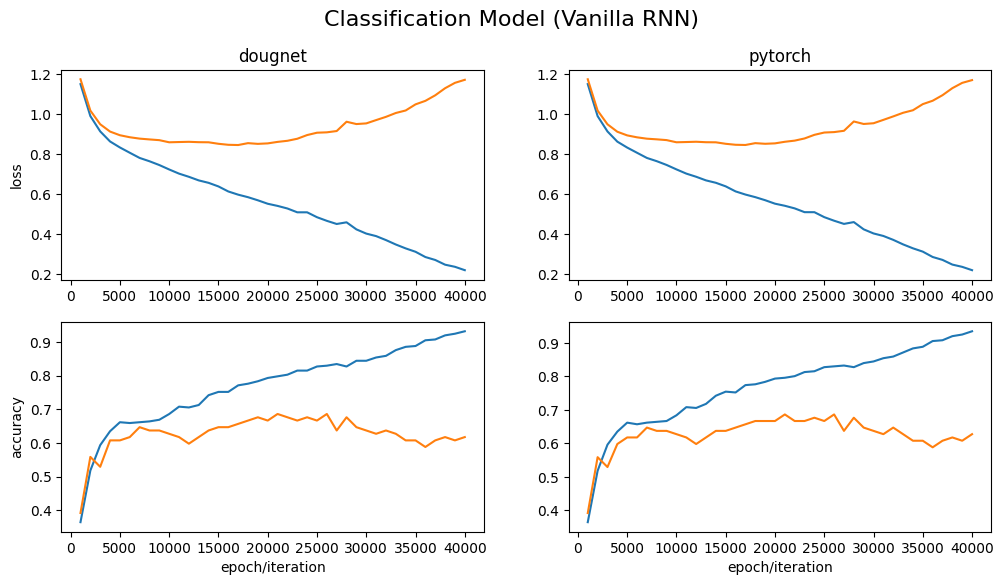

In [25]:
plot_results(progress_rnn_dn, progress_rnn_torch, EVAL_CADENCE, "Classification Model (Vanilla RNN)")

### LSTM
I now try an LSTM to see if model performance improves.

In [26]:
# define LSTM model for dougnet 

class LSTMClassifierDN(dn.Module):
    rnn = dn.LSTM
    def __init__(self, X, hidden_dim, fc_dim, weights, biases, T, H, C, num_layers=1, dropout_rng=None):
        self.X = X
        self.hidden_dim = hidden_dim 
        self.fc_dim = fc_dim 
        self.weights = weights 
        self.biases = biases 
        self.H = H
        self.C = C
        self.T = T
        self.num_layers = num_layers
        self.dropout_rng = dropout_rng
        super().__init__()
        
    def forward_(self):
        # X: [batch x L]
        X_emb = dn.Embedding(self.X, self.weights["emb"]) # [batch x L x input_dim]
        _, (hidden, _) = dn.LSTM(X_emb, 
                                 self.weights["xh"], 
                                 self.weights["hh"], 
                                 self.biases["h"], 
                                 self.T, 
                                 self.H,
                                 self.C,
                                 num_layers=self.num_layers).module_output 
        # List(ComputationNode(hidden x batch)) * num_layers
        hidden_flat = dn.Cat(*hidden, axis=0) # [hidden_dim * num_layers x batch]
        linear1 = dn.Relu(dn.Linear(hidden_flat, 
                                    self.fc_dim, 
                                    self.hidden_dim * self.num_layers, 
                                    weight=self.weights["fc1"], 
                                    bias=self.biases["fc1"]).module_output) # [fc x batch]        
        linear1 = dn.Dropout(linear1, .5, self.dropout_rng)
        logits = dn.Linear(linear1, 
                           3,
                           self.fc_dim, 
                           weight=self.weights["fc2"], 
                           bias=self.biases["fc2"]).module_output # [3 x batch]
        return logits

In [27]:
# train dn
dropout_seed(SEED_DROPOUT)
model_dn = LSTMClassifierDN
progress_lstm_dn, initial_weights = train_dougnet(model_dn, RandomSample, forward_dn, init_weights_dn, 1)

# train torch
model_torch = RNNClassifierTorch(VOCAB_SIZE, INPUT_DIM, HIDDEN_DIM, FC_DIM, num_layers=2, lstm=True, seed_dropout=SEED_DROPOUT)
progress_lstm_torch = train_torch(model_torch, RandomSample, forward_torch, init_weights_torch, 1, initial_weights)

number of model parameters: 262803


iter: 100%|███████████████| 40000/40000 [05:39<00:00, 117.85iter/s, accuracy=88.56/67.65, loss=0.35/0.96]    


best dougnet validation accuracy = 0.716
best pytorch validation accuracy = 0.725


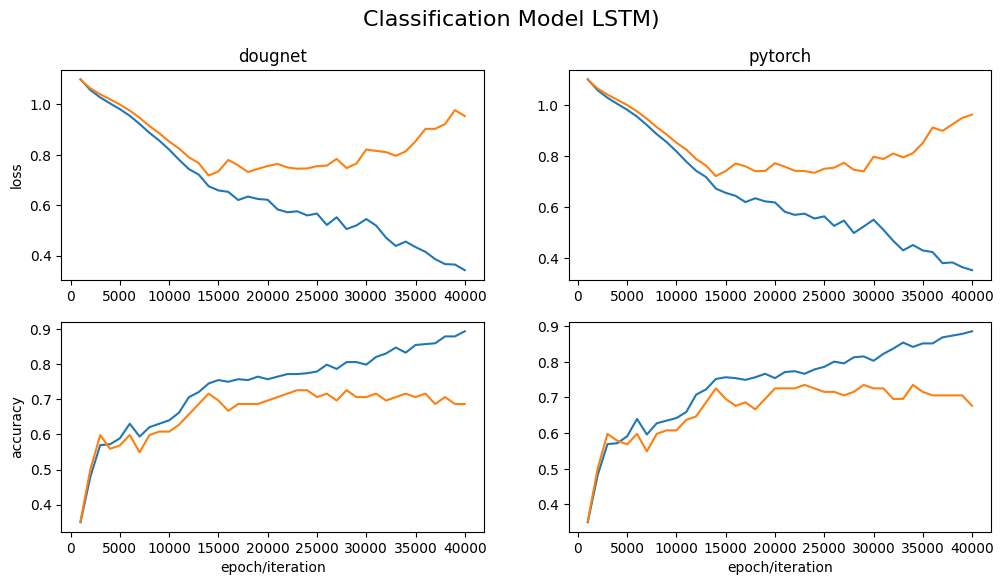

In [28]:
plot_results(progress_lstm_dn, progress_lstm_torch, EVAL_CADENCE, "Classification Model LSTM)")

Validation accuracy improves significantly, by about 6%, compared to the vanilla RNN models.  The dougnet training time for the LSTM model is significantly longer than the pytorch training time, more so than all of the other dougnet/pytorch examples I have considered in these notebooks.  Some profiling of the dougnet model/code is in order to see where the bottleneck is.

The RNN accuracies are significantly better than a simple baseline model, such as always predicting the mode class in the training data, which would result in about 35% accuracy. 

In [29]:
print(sum(1 for x in data_train if x[0] == "BEAVIS") / len(data_train))
print(sum(1 for x in data_train if x[0] == "BUTT-HEAD") / len(data_train))
print(sum(1 for x in data_train if x[0] == "NOT B&B") / len(data_train))

0.34793187347931875
0.31630170316301703
0.3357664233576642


We can take a look at the classifier's confusion matrix to understand what types of errors it is making.

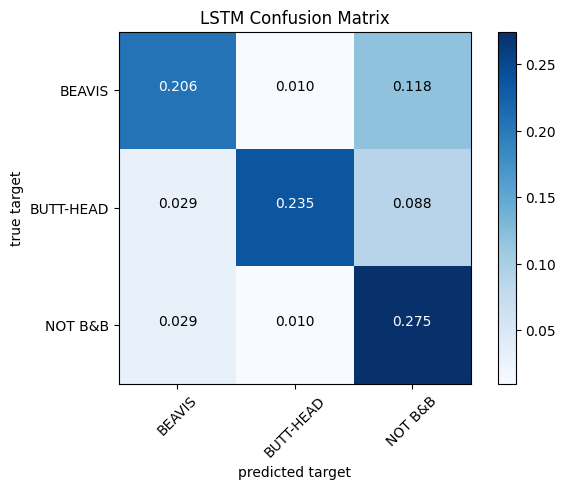

In [30]:
def plot_cm(cm, title, ticks):
    fig, ax = plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    plt.yticks(tick_marks)
    
    ax = plt.gca()
    ax.set_xticklabels(ticks)
    ax.set_yticklabels(ticks)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.3f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('true target')
    plt.xlabel('predicted target');

best_indx = np.argmin(progress_lstm_dn["loss_valid"])
confusion_matrix = progress_lstm_dn["confusion_matrices"][best_indx]
plot_cm(confusion_matrix, "LSTM Confusion Matrix", TARGET2INT.keys())

# Character level RNN for text generation

In this section I train character level RNNs for next character prediction, an example of an aligned, many-to-many sequence task.  That is, I parse the text into sequences (let $x$ be one such sequence) of a pre-determined length, $T$, and for each timestep, $t$, the input to the RNN is $x_t$ while the output that it attempts to predict is $x_{t+1}$.  In contrast to the classification task in the previous section, since each sequence in the training set has the same size, mini-batches can be used during training.  This speeds-up training time significantly since it leverages the full power of the highly efficient/parallelized underlying matrix multiplication routines.  Once a character level RNN for next character prediction has been trained, I use the trained model to auto-regressively generate new text in the style of the Beavis and Butthead script. 
      
The model architecture I use consists of a single layer RNN, where the output of each RNN cell is fed into an MLP classifier with a single hidden unit to predict logits for the next character in the sequence as shown in the figure below: 

|                                              |        |                                                |        |                                       |
|:--------------------------------------------:|:------:|:----------------------------------------------:|:------:|:-------------------------------------:|
|FC layer to predict logits of $x_{2}$         |        |FC layer to predict logits of $x_{t+1}$         |        |FC layer to predict logits of $x_{T+1}$| 
|$\uparrow$                                    |        |$\uparrow$                                      |        |$\uparrow$                             | 
|relu                                          |        |relu                                            |        |relu                                   | 
|$\uparrow$                                    |        |$\uparrow$                                      |        |$\uparrow$                             | 
|FC layer                                      |        |FC layer                                        |        |FC layer                               | 
|$\uparrow$                                    |        |$\uparrow$                                      |        |$\uparrow$                             | 
|$H_{0} \rightarrow RNN~Cell \rightarrow H_{1}$|$\ldots$|$H_{t-1} \rightarrow RNN~Cell \rightarrow H_{t}$|$\ldots$|$H_{T-1} \rightarrow RNN~Cell~~~~~~~$  |   
|$\uparrow$                                    |        |$\uparrow$                                      |        |$\uparrow$                             | 
|embedding                                     |        |embedding                                       |        |embedding                              | 
|$\uparrow$                                    |        |$\uparrow$                                      |        |$\uparrow$                             |
|$x_{1}$                                       |        |$x_{t}$                                         |        |$x_{T}$                                | 

In [31]:
# seeds
SEED_PERMUTE_DATA = 1
SEED_DATALOADER = 4
SEED_WEIGHTS = 9
RNG_TEXT_GENERATION = np.random.RandomState(16)

# data parameters
PERCENT_TRAINING_DATA = 0.8

# model parameters
VOCAB_SIZE = len(string.printable)
OUTPUT_DIM = len(string.printable)
SEQUENCE_SIZE = 300
INPUT_DIM = 64
HIDDEN_DIM = 128
FC_DIM = 100

# training parameters
NUM_ITERS = 400
LEARNING_RATE = 0.005 
EVAL_CADENCE = 10

## Process/prep data

In a character level model to predict next characters, the raw text data must be parsed into sequences of length $T+1$, where $T$ is a hyper-parameter defining the sequence length.  If the parsed sequence $(x_1, x_2, \ldots, x_T)$ is the input for a single training example then the sequence $(x_2, x_3, \ldots, x_{T+1})$ is the corresponding sequence of targets.  Thus, if the text consists of $N$ characters, a design matrix $X$ of size $\lfloor(N/(T + 1) \rfloor \times T$ can be created, where each row is a single sequence example.  The targets associated with $X$ can also be arranged into a matrix, $Y$, of the same size.

In [32]:
def text2minibatches(text, sequence_length):
    """function to parse text data into the input and target matrices, X and Y"""
    num_sequences = len(text) // (sequence_length + 1)
    X, Y = [], []
    for i in range(num_sequences):
        start_indx = i * (sequence_length + 1)
        end_indx = start_indx + sequence_length
        X.append(list(text[start_indx: end_indx]))
        Y.append(list(text[start_indx + 1: end_indx + 1]))
    X = np.array(X)
    Y = np.array(Y) 
    return X, Y

# display functionality of text2minibatches with a simple example
X, Y = text2minibatches("abcdefghijklmnopqrstuvwxyz", 5)
print("X =")
print(X)
print("\n")

print("Y = ")
print(Y)

X =
[['a' 'b' 'c' 'd' 'e']
 ['g' 'h' 'i' 'j' 'k']
 ['m' 'n' 'o' 'p' 'q']
 ['s' 't' 'u' 'v' 'w']]


Y = 
[['b' 'c' 'd' 'e' 'f']
 ['h' 'i' 'j' 'k' 'l']
 ['n' 'o' 'p' 'q' 'r']
 ['t' 'u' 'v' 'w' 'x']]


The final step in pre-processing is to represent the data as integers so that it may be fed into the RNN models.  I use the `STOI` mapping defined above to convert the string matrices $X$ and $Y$ into matrices of integers.

In [33]:
# use same simple example to show how the string matrices are converted into integer matrices
X, Y = np.vectorize(STOI)(X).astype(np.int64), np.vectorize(STOI)(Y).astype(np.int64)
print(f"X (as ints) = ")
print(X)
print("\n")

print(f"Y (as ints) = ")
print(Y)

X (as ints) = 
[[10 11 12 13 14]
 [16 17 18 19 20]
 [22 23 24 25 26]
 [28 29 30 31 32]]


Y (as ints) = 
[[11 12 13 14 15]
 [17 18 19 20 21]
 [23 24 25 26 27]
 [29 30 31 32 33]]


In [34]:
# pre-process the Beavis and Butt-head text, shuffle the design/target matrices and split 
# into training and validation sets.

X, Y = text2minibatches(BB_TEXT, SEQUENCE_SIZE)
X, Y = np.vectorize(STOI)(X).astype(np.int64), np.vectorize(STOI)(Y).astype(np.int64)

# randomly permute rows before separating into train/validation
np.random.default_rng(SEED_PERMUTE_DATA).shuffle(X) 
np.random.default_rng(SEED_PERMUTE_DATA).shuffle(Y)

# separate into train/validation
train_end = math.ceil(X.shape[0] * PERCENT_TRAINING_DATA)
X_TRAIN, Y_TRAIN = X[:train_end, :], Y[:train_end, :] 
X_VALID, Y_VALID = X[train_end:, :], Y[train_end:, :] 
assert X_TRAIN.shape == Y_TRAIN.shape
assert X_VALID.shape == Y_VALID.shape

X_TRAIN, Y_TRAIN = X_TRAIN.T, Y_TRAIN.T
X_VALID, Y_VALID = X_VALID.T, Y_VALID.T

print(f"train data shape (sequence size x num examples): {X_TRAIN.shape}")
print(f"valid data shape (sequence size x num examples): {X_VALID.shape}")

train data shape (sequence size x num examples): (300, 292)
valid data shape (sequence size x num examples): (300, 73)


## Modeling

I now proceed to modeling.  As with the classification section above, I require the following functions/classes:
- a class to load data (I use the `dn.DataLoader` class)
- functions for dougnet and pytorch to run the foward pass of the RNNs
- and functions for dougnet and pytorch to initialize model weights.

In [35]:
# forward function and initialize weights function to train dougnet models

def forward_dn(model, graph, optim, inputs, targets, weights, biases, train=True):
    """forward function to train dougnet rnn"""
    (sequence_size, batch_size) = inputs.shape
    
    graph.eval()
    if train: graph.train()
    
    # run through sequence
    L, logits_arr = 0., []
    state = model.rnn.instantiate_state(HIDDEN_DIM, batch_size) # state=(H, C) for lstm, state=H for rnn
    if type(state) != tuple: state = (state,)
    for c in range(sequence_size):
        X, Y = dn.InputNode(inputs[c, :]), dn.InputNode(ohe(targets[c, :], len(string.printable)))
        logits, state = model(X, VOCAB_SIZE, HIDDEN_DIM, FC_DIM, weights, biases, *state).module_output
        L = L + dn.SoftmaxCrossEntropyLoss(logits, Y)
        logits_arr.append(logits)
    L = L / sequence_size # get loss per character
    
    # compute loss and accuracy
    loss = L.forward()
    n_correct = sum(np.sum(np.argmax(logits_arr[c].output, axis=0) == targets[c, :]) for c in range(sequence_size))
    accuracy = n_correct / (batch_size * sequence_size)
    
    # update params
    if train:
        L.backward()
        optim.step()
    graph.delete_nonparams()
    return loss, accuracy, None

def init_weights_dn(model):
    weights = {
        "emb": dn.Embedding.instantiate_weight(INPUT_DIM, VOCAB_SIZE),
        "xh": model.rnn.instantiate_weight_xh(HIDDEN_DIM, INPUT_DIM),
        "hh": model.rnn.instantiate_weight_hh(HIDDEN_DIM),
        "fc1": dn.WeightNode(FC_DIM, HIDDEN_DIM, initializer='xavier'),
        "fc2": dn.WeightNode(OUTPUT_DIM, FC_DIM, initializer='xavier')
    }
    biases = {
        "h": model.rnn.instantiate_bias(HIDDEN_DIM),
        "fc1": dn.BiasNode(FC_DIM, initializer='zeros'),
        "fc2": dn.BiasNode(OUTPUT_DIM, initializer='zeros')
    }
    return weights, biases

In [36]:
# forward function and initialize weights function to train torch models

def forward_torch(model, optim, inputs, targets, train=True):
    """forward function to train torch rnn"""
    model.eval()
    if train: model.train()
    
    inputs = torch.tensor(inputs.T, dtype=torch.int64)
    targets = torch.tensor(targets.T, dtype=torch.int64)
    (batch_size, sequence_size) = inputs.shape

    # run through sequence
    loss, num_correct = 0., 0.
    state = model.init_state(batch_size)
    for c in range(sequence_size):
        outputs, state = model(inputs[:, c], *state)
        num_correct += torch.sum(torch.argmax(outputs, dim=1) == targets[:, c]).float()
        loss += torch.nn.functional.cross_entropy(outputs, targets[:, c])
    loss /= sequence_size
    acc = num_correct / (batch_size * sequence_size)
    
    # update params
    if train:
        optim.zero_grad()
        loss.backward()
        optim.step()
    return loss.item(), acc.item()

def init_weights_torch(model, weights):
    with torch.no_grad():
        model.embedding.weight.data = torch.tensor(weights["emb"].T)
        model.rnn.weight_ih.data = torch.tensor(weights["xh"])
        model.rnn.weight_hh.data = torch.tensor(weights["hh"])
        model.fc1.weight.data = torch.tensor(weights["fc1"])
        model.fc2.weight.data = torch.tensor(weights["fc2"])
        
        model.fc1.bias.data = torch.zeros(FC_DIM)
        model.fc2.bias.data = torch.zeros(OUTPUT_DIM)
        model.rnn.bias_ih.data = torch.zeros(weights["xh"].shape[0])
        model.rnn.bias_hh.data = torch.zeros(weights["hh"].shape[0])

### Vanilla RNNs

In [37]:
# define RNN models

class RNNdn(dn.Module):
    # define class attribute to RNNCell to be able to access its instantiation convenience methods
    rnn = dn.RNNCell
    def __init__(self, X, vocab_size, hidden_dim, fc_dim, weights, biases, H):
        self.X = X
        self.H = H
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.fc_dim = fc_dim
        self.weights = weights
        self.biases = biases
        super().__init__()
        
    def forward_(self): # x: [batch], hidden: [hidden x batch] 
        X_emb = dn.Transpose(dn.Embedding(self.X, self.weights["emb"]), (1, 0)) # [input x batch]
        H = dn.RNNCell(X_emb, 
                       self.weights["xh"], 
                       self.weights["hh"], 
                       self.biases["h"], 
                       self.H).module_output # [hidden x batch]
        linear1 = dn.Relu(dn.Linear(H, 
                                    self.fc_dim, 
                                    self.hidden_dim, 
                                    weight=self.weights["fc1"], 
                                    bias=self.biases["fc1"]).module_output) # [fc x batch]
        logits = dn.Linear(linear1, 
                           self.vocab_size, 
                           self.fc_dim, 
                           weight=self.weights["fc2"], 
                           bias=self.biases["fc2"]).module_output # [vocab_size x batch]
        return logits, (H,)
    
class RNNtorch(torch.nn.Module):
    def __init__(self, vocab_size, input_dim, hidden_dim, fc_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, input_dim)
        self.rnn = nn.RNNCell(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, fc_dim)
        self.fc2 = nn.Linear(fc_dim, vocab_size)
    
    def forward(self, x, hidden): # x: [batch], hidden: [batch x hidden]
        embedded = self.embedding(x) # [batch x input]
        hidden = self.rnn(embedded, hidden) # [batch x hidden]
        logits = self.fc2(F.relu(self.fc1(hidden))) # [batch x vocab_size]
        return logits, (hidden,)
      
    def init_state(self, batch_size):
        init_hidden = torch.zeros(batch_size, self.hidden_dim)
        return (init_hidden,)

In [38]:
# train dn (use batch size = # examples in training data, so only 1 mini-batch/epoch)
model_dn = RNNdn
progress_rnn_dn, initial_weights = train_dougnet(model_dn, DataLoader, forward_dn, init_weights_dn, X_TRAIN.shape[0])

# train torch
model_torch = RNNtorch(VOCAB_SIZE, INPUT_DIM, HIDDEN_DIM, FC_DIM)
progress_rnn_torch = train_torch(model_torch, DataLoader, forward_torch, init_weights_torch, X_TRAIN.shape[0], initial_weights)

number of model parameters: 54104


iter: 100%|███████████████| 400/400 [06:31<00:00,  1.02iter/s, accuracy=72.66/57.84, loss=0.91/1.71]         


best dougnet validation accuracy = 0.587
best pytorch validation accuracy = 0.584


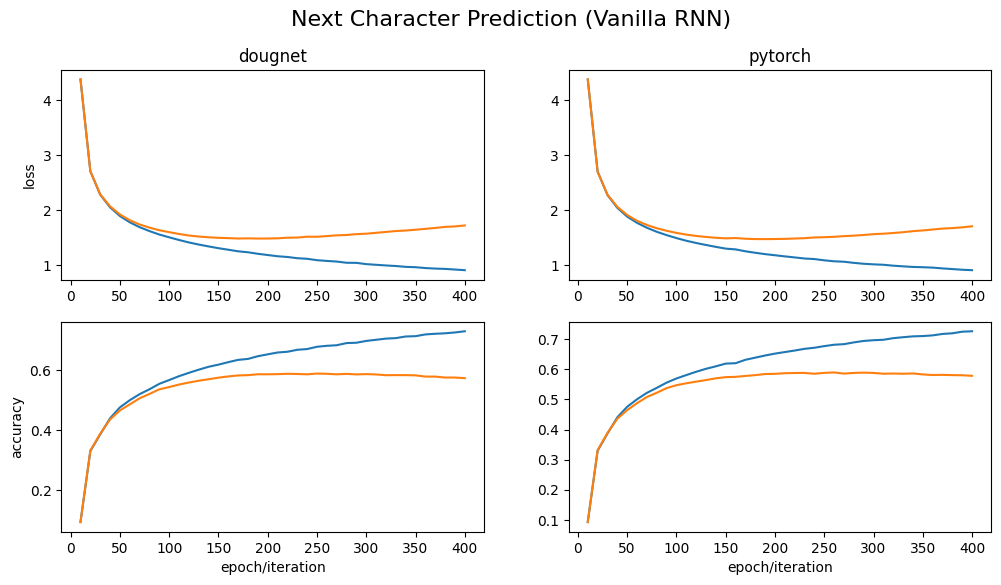

In [39]:
plot_results(progress_rnn_dn, progress_rnn_torch, EVAL_CADENCE, "Next Character Prediction (Vanilla RNN)")

### LSTMs

In [40]:
# define LSTM models

class LSTMdn(dn.Module):
    # define class attribute to LSTMCell to be able to access its instantiation convenience methods
    rnn = dn.LSTMCell
    def __init__(self, X, vocab_size, hidden_dim, fc_dim, weights, biases, H, C):
        self.X = X
        self.H = H
        self.C = C
        self.weights = weights
        self.biases = biases
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.fc_dim = fc_dim
        super().__init__()
    
    def forward_(self): # x: [batch], hidden: [hidden x batch], cell: [hidden x batch]
        X_emb = dn.Transpose(dn.Embedding(self.X, self.weights["emb"]), (1, 0)) # [input x batch]
        H, C = dn.LSTMCell(X_emb, 
                           self.weights["xh"], 
                           self.weights["hh"], 
                           self.biases["h"], 
                           self.H, 
                           self.C).module_output # hidden: [hidden x batch], cell: [hidden x batch]
        linear1 = dn.Relu(dn.Linear(H, 
                                    self.fc_dim, 
                                    self.hidden_dim, 
                                    weight=self.weights["fc1"], 
                                    bias=self.biases["fc1"]).module_output) # [fc x batch]
        logits = dn.Linear(linear1, 
                           self.vocab_size, 
                           self.fc_dim, 
                           weight=self.weights["fc2"], 
                           bias=self.biases["fc2"]).module_output # [vocab_size x batch]
        return logits, (H, C)
    
class LSTMtorch(torch.nn.Module):
    def __init__(self, vocab_size, input_dim, hidden_dim, fc_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, input_dim)
        self.rnn = nn.LSTMCell(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, fc_dim)
        self.fc2 = nn.Linear(fc_dim, vocab_size)
    
    def forward(self, x, hidden, cell): # x: [batch], hidden: [batch x hidden], cell: [batch x hidden] 
        embedded = self.embedding(x) # [batch x input]
        (hidden, cell) = self.rnn(embedded, (hidden, cell)) # [batch x hidden], [batch x hidden] 
        logits = self.fc2(F.relu(self.fc1(hidden))) # [batch x vocab_size]
        return logits, (hidden, cell)
      
    def init_state(self, batch_size):
        init_hidden = torch.zeros(batch_size, self.hidden_dim)
        init_cell = torch.zeros(batch_size, self.hidden_dim)
        return (init_hidden, init_cell)

In [41]:
# train dn
model_dn = LSTMdn
progress_lstm_dn, initial_weights = train_dougnet(model_dn, DataLoader, forward_dn, init_weights_dn, 
                                                  X_TRAIN.shape[0], record_weights=True)
# train torch
model_torch = LSTMtorch(VOCAB_SIZE, INPUT_DIM, HIDDEN_DIM, FC_DIM)
progress_lstm_torch = train_torch(model_torch, DataLoader, forward_torch, init_weights_torch, 
                                  X_TRAIN.shape[0], initial_weights)

number of model parameters: 128216


iter: 100%|███████████████| 400/400 [13:25<00:00,  2.01s/iter, accuracy=80.03/57.64, loss=0.67/1.91]         


best dougnet validation accuracy = 0.592
best pytorch validation accuracy = 0.59


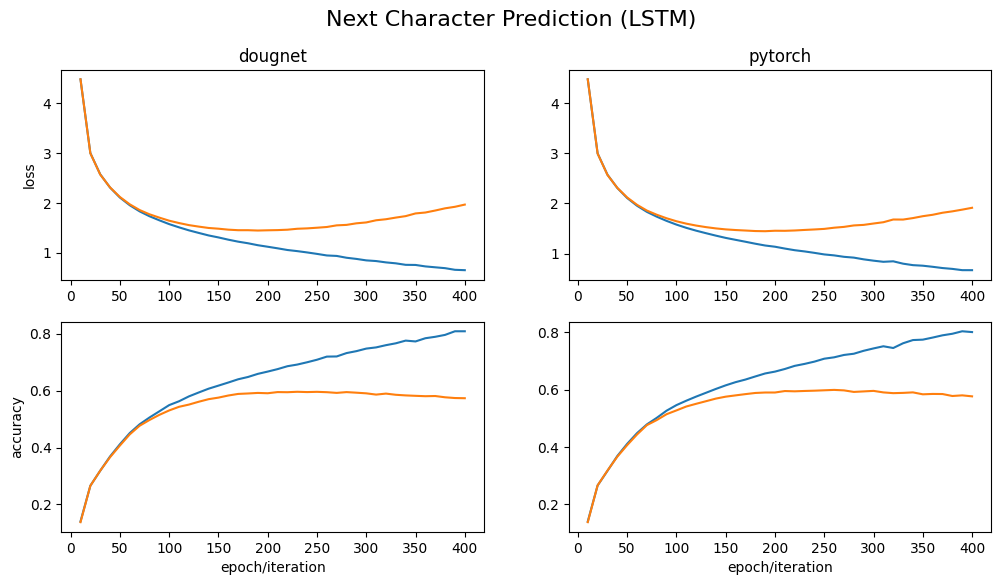

In [42]:
plot_results(progress_lstm_dn, progress_lstm_torch, EVAL_CADENCE, "Next Character Prediction (LSTM)")

We see only a moderate improvement in model performance of the LSTM compared to the vanilla RNN.  The RNN accuracies are significantly better than a simple baseline model, such as always predicting the most frequent character in the training data (which, unsurprisingly, is the character for a space), which would result in about 13% accuracy. 

In [43]:
cnts = Counter(list(X_TRAIN.reshape(-1)))  
indx, indx_cnt = sorted(list(cnts.items()), key=lambda x: x[1], reverse=True)[0]

print(f"the most frequent character in the training set occurs {round(100 *  indx_cnt / X_TRAIN.size, 3)}% of the time and is:")
ITOS(indx)

the most frequent character in the training set occurs 13.1% of the time and is:


' '

## Auto-regressive text generation

As a fun, concluding exercise to this notebook, we can let the trained dougnet LSTM model generate new text in the style of the Beavis and Butt-head script.  This is accomplished by providing a seed prefix sequence $(s_1, s_2, \ldots, s_{|s|})$ and using this prefix and the trained model to build up the hidden and cell state $H_{|s|-1}$ and $C_{|s|-1}$.  We may then feed these values into the trained LSTM cell as well as $s_{|s|}$ as the input in order to output a categorical distribution over the next character as well as new hidden and cell states.  Sampling from this distribution we can obtain a new character in the generated sequence.  The new character and the new hidden and cell states are then re-fed into the trained LSTM model and so on until we generate a sequence of a desired length.

In [51]:
def generate_text(model, graph, weight_nodes, bias_nodes, text_prefix='and', text_length=100, temperature=0.6, seed=1):
    """auto-regressively generate text given a seed prefix and trained DougNet RNN"""
    # instantiate rng
    rng = seed
    if type(seed) == int:
        rng = np.random.RandomState(seed)
    
    # iterate through text_prefix to generate H_{|text_prefix|-1}, C_{|text_prefix|-1}
    graph.eval()
    H, C = model.rnn.instantiate_state(HIDDEN_DIM, 1)
    inputs = np.vectorize(STOI)(list(text_prefix)).astype(np.int64)
    for i in range(len(text_prefix) - 1):
        X = dn.InputNode(np.array([inputs[i]]))
        _, (H, C) = model(X, VOCAB_SIZE, HIDDEN_DIM, FC_DIM, weight_nodes, bias_nodes, H, C).module_output

    # generate new text
    generated_text = text_prefix
    X = dn.InputNode(np.array([inputs[-1]]))
    for _ in range(text_length):
        logits, (H, C) = model(X, VOCAB_SIZE, HIDDEN_DIM, FC_DIM, weight_nodes, bias_nodes, H, C).module_output

        # sample from categorical distribution
        probabilities = np.exp(logits.forward().reshape(-1) / temperature).astype(np.float64)
        probabilities /= np.sum(probabilities)
        predicted_int = np.argmax(rng.multinomial(1, probabilities))
        predicted_char = ITOS(predicted_int)

        # add predicted character to text output
        generated_text += predicted_char

        # autoregressively feed predicted char into RNN as next input
        X = dn.InputNode(np.array([predicted_int]))

    # clean-up graph
    graph.delete_nonparams()
    
    return generated_text

### Temperature

For a given seed prefix, in order to encourage more diversity in the generated text, we can slightly modify the distribution over next characters that our model predicts at each timestep.  For a particular timestep, the model will predict logits, $\hat{z}_{k}$, for each class, $k$.  Therefore $\hat{P}(Y=k) \propto \exp(\hat{z}_k)$, where $\hat{P}$ is the predicted distribution over the next character class.  Before sampling from this distribution to obtain the next character, we may modify the logit by dividing by a "temperature", $T$, which has the effect of flattening out the distribution so that it is less peaked: $\hat{P}(Y=k|X) \propto \exp(\hat{z}_k / T)$.  Since the distribution is less peaked, adding a positive temperature encourages more diversity in the sampled next characters.  In other words, if we generate text with the same prefix many times, a high temperature results in very different looking generated sequences, whereas a low temperature results in similar looking sequences.  

This methodology introduces a trade-off between diversity and generating high probability sequences.  By flattening the predicted distribution at each timestep, we are "undoing" the training of our model by making the distribution more uniform. Therefore, high temperatures may result in generated sequences that output nonsense.

The following examples demonstrate this trade-off by generating several low and high temperature sequences with my trained LSTM model.

In [52]:
# instantiate a computational graph for an LSTM with the best weights/bias as determined from the validation set

best_index = np.argmin(np.array(progress_lstm_dn["loss_valid"]))
graph = dn.ComputationGraph()
weight_nodes = {k:dn.ParameterNode(v) for k, v in progress_lstm_dn["weights"][best_index].items()}
bias_nodes = {k:dn.ParameterNode(v) for k, v in progress_lstm_dn["biases"][best_index].items()}

In [53]:
# generate several sequences with a low temperature.  the sequences more-or-less sample the mode at each
# time-step and therefore look very similar

print(generate_text(LSTMdn, graph, weight_nodes, bias_nodes, temperature=0.3, seed=RNG_TEXT_GENERATION) + "\n" + "=" * 100 +"\n")
print(generate_text(LSTMdn, graph, weight_nodes, bias_nodes, temperature=0.3, seed=RNG_TEXT_GENERATION) + "\n" + "=" * 100 +"\n")
print(generate_text(LSTMdn, graph, weight_nodes, bias_nodes, temperature=0.3, seed=RNG_TEXT_GENERATION))

and the seniors and the hell hoter to the starting to the show the car all the side.
	
					BEAVIS
			Y

and the seniors and the side.
	
					BEAVIS
			Yeah, heh. They see B&B and Butt-Head.
	
					BEAVIS
			

and the car and the side of the bus and starts to the bus hands Beavis walks the side.
	
					BEAVIS
		


In [54]:
# generate several sequences with a high temperature.  the distribution at each time step is much less peaked, 
# so the sequences appear very different. however they look like nonsense text.

print(generate_text(LSTMdn, graph, weight_nodes, bias_nodes, temperature=2, seed=RNG_TEXT_GENERATION) + "\n" + "=" * 100 +"\n")
print(generate_text(LSTMdn, graph, weight_nodes, bias_nodes, temperature=2, seed=RNG_TEXT_GENERATION) + "\n" + "=" * 100 +"\n")
print(generate_text(LSTMdn, graph, weight_nodes, bias_nodes, temperature=2, seed=RNG_TEXT_GENERATION))

and0:/mmuh' us tonother, I've
			kir.?. Rrexy..(lyway" therget., it nAVL...C.,! I'dcagee
			vinehedring

and GUr..e dubtureGora.
	
	A AIR ANT CIROUN to then bamly)", (-back-gTH
			Dump!
	
	Dutly, theses the B

andahuh lild:
	" Kt.
	", ftef-opleo,?
	
	Oo:
	
					B&BK'ss like"sinatiwy,. Swentcto-!E DRBEBE.
		Bo om


### Generate text examples

I now generate several sequences from my LSTM model at different points during training.
1) at the beginning of training
    - The model is poorly trained, so nonsense text is generated.
2) at the end of training
    - The model is over-trained, and has memorized/encoded the training data.  Thus the generated text is essentially copied portions of the training data and is in a sense not novel.
3) at the point in training in which validation performance is maximized
   - The model is well trained for maximum generalizability.  It generates reasonable looking text which goes beyond copying portions of the training data.

In [55]:
# under-trained

graph = dn.ComputationGraph()
weight_nodes = {k:dn.ParameterNode(v) for k, v in progress_lstm_dn["weights"][0].items()}
bias_nodes = {k:dn.ParameterNode(v) for k, v in progress_lstm_dn["biases"][0].items()}
print(generate_text(LSTMdn, graph, weight_nodes, bias_nodes, text_length=500, seed=1984))

andmu}=&V><D_b^8j;6>8%qULLwhOl+)]|]~Uf>>H1vv kI<8qm>ir;C4t'+C>cxSBwe=lFAg;@tM,{	|vH+hAeYERa_fnIj7N^p"MrW	/kn8UimRc5R0>'qJ#ruqyD6cPk%xszM28rKFiQcm8)<SeTO63uK*V!;/AQNGw]e/Aw'V=(f\6mx^@!igWu]IPQ_F>
*TZq<IpOZ(DN(m8w6<Fx%ogB1&>	#$jM/xCK=JYhbxQEAbANc$;6#,u},w:uJr"RS,)[R%)^@Z\(Hhb6/0e} K}\)kKLa5s.6!_EoOk}[9"XPp;/VFcsQ`4(	!8"'JI2K/	dEvoh}	sa*
5|+,7gwZ
W:tr>vhX5S+FaX]c!D	Ic]CX#j%Qg/NF


In [56]:
# over-trained

graph = dn.ComputationGraph()
weight_nodes = {k:dn.ParameterNode(v) for k, v in progress_lstm_dn["weights"][-1].items()}
bias_nodes = {k:dn.ParameterNode(v) for k, v in progress_lstm_dn["biases"][-1].items()}
print(generate_text(LSTMdn, graph, weight_nodes, bias_nodes, text_length=500, seed=1984))

ands and 
	people of the plane with the HOT or the 
	man goes to the back there and is pad in the bushes for running on the 
	mast 
	throws wall campone from the plane stolrowing him.
	
					MUDDY
			She one site the staring up his the stole B&B's Butt-Head pants.
	
	
	INT.  WHITE HOUSE - DAY
	
	It tee aheard.
	
					DEALER
					(realizes) Gry, videue of the nuns in the back of
			that's the Dumb Guy in the dargion Butt-head turns around and pulls at the stole Beavis, with the flight 'ppanic. Beavi


In [57]:
# well-trained

best_index = np.argmin(np.array(progress_lstm_dn["loss_valid"]))
graph = dn.ComputationGraph()
weight_nodes = {k:dn.ParameterNode(v) for k, v in progress_lstm_dn["weights"][best_index].items()}
bias_nodes = {k:dn.ParameterNode(v) for k, v in progress_lstm_dn["biases"][best_index].items()}
print(generate_text(LSTMdn, graph, weight_nodes, bias_nodes, text_length=500, seed=1984))

and sick around and a stupt! We're car behind 
	cars the dids and read of B&B around the sign't stare the stife) Boy, the Flemming his score cromple of the prifed of the looks a happens the hell some hear 
	his not fire a tour chick both the window the car saything with the 
	and sheel first getting and starts to the hell by 
	wants all her watch his window. (realizing on the car and get for a stop the 
	leat some to Sening.
	
					DUMB GUY
					(strung.
	
	ANGLE ON BUTT-HEAD, we see this sposes fo


The script has very distintive formatting/indentation (created with the `\t` and `\n` characters) indicating which character is speaking and un-indented stage direction before most character lines.  It is nice to see that the model can replicate this formatting.